Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import os

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#pickle_file = 'notMNIST.pickle'
pickle_file = 'notMNIST_noDupNorOvlp.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 28, 28) (438047,)
Validation set (15586, 28, 28) (15586,)
Test set (13645, 28, 28) (13645,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 28, 28, 1) (438047, 10)
Validation set (15586, 28, 28, 1) (15586, 10)
Test set (13645, 28, 28, 1) (13645, 10)


In [7]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [4]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [5]:
num_steps = 1001

#Plots
p_freq = 10
losses = []
accuracies = []
rates = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    #Plot variables
    if (step % p_freq == 0):
       losses.append(l)
       accuracies.append(accuracy(valid_prediction.eval(), valid_labels))
       rates.append(0.05)
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps, p_freq), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, num_steps, p_freq), accuracies)
ax2.set_ylabel("Validation accuracy")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, num_steps, p_freq), rates)
ax3.set_ylabel("Learning rate")
ax3.set_xlabel("Training steps")
ax3.set_ylim([0, 1])
plt.show()

Initialized


NameError: name 'accuracy' is not defined

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [10]:
batch_size = 256
patch_size = 5
depth = 16
num_hidden = 128

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Convolution 1 Layer
  # Input channels: num_channels = 1
  # Output channels: depth = 16
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))

  # Convolution 2 Layer
  # Input channels: depth = 16
  # Output channels: depth = 16
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
  # Fully Connected Layer (Densely Connected Layer)
  # Use neurons to allow processing of entire image
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
  # Readout layer: Softmax Layer
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    # ksize is kernel size = [1, 2, 2, 1]
    padd1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.conv2d(padd1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    padd2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = padd2.get_shape().as_list()
    reshape = tf.reshape(padd2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 5.904369
Minibatch accuracy: 5.9%
Validation accuracy: 10.9%
Minibatch loss at step 50: 1.204750
Minibatch accuracy: 69.1%
Validation accuracy: 69.1%
Minibatch loss at step 100: 0.796132
Minibatch accuracy: 78.1%
Validation accuracy: 76.1%
Minibatch loss at step 150: 0.877606
Minibatch accuracy: 74.2%
Validation accuracy: 78.1%
Minibatch loss at step 200: 0.707778
Minibatch accuracy: 80.9%
Validation accuracy: 79.3%
Minibatch loss at step 250: 0.720796
Minibatch accuracy: 80.9%
Validation accuracy: 79.9%
Minibatch loss at step 300: 0.665944
Minibatch accuracy: 81.2%
Validation accuracy: 80.4%
Minibatch loss at step 350: 0.625352
Minibatch accuracy: 80.5%
Validation accuracy: 80.8%
Minibatch loss at step 400: 0.582612
Minibatch accuracy: 81.2%
Validation accuracy: 81.8%
Minibatch loss at step 450: 0.598311
Minibatch accuracy: 83.2%
Validation accuracy: 81.9%
Minibatch loss at step 500: 0.481240
Minibatch accuracy: 85.9%
Validation accuracy: 82.7%
Mi

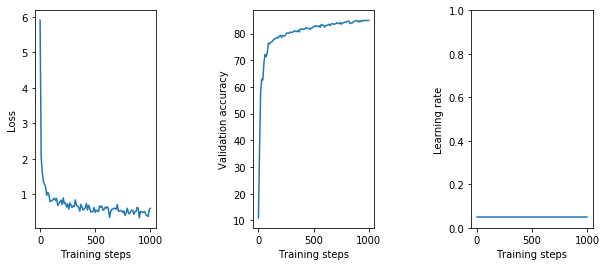

In [11]:
num_steps = 1001

#Plots
p_freq = 10
losses = []
accuracies = []
rates = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    #Plot variables
    if (step % p_freq == 0):
       losses.append(l)
       accuracies.append(accuracy(valid_prediction.eval(), valid_labels))
       rates.append(0.05)
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps, p_freq), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, num_steps, p_freq), accuracies)
ax2.set_ylabel("Validation accuracy")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, num_steps, p_freq), rates)
ax3.set_ylabel("Learning rate")
ax3.set_xlabel("Training steps")
ax3.set_ylim([0, 1])
plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [73]:
batch_size = 512
patch_size1 = 5
patch_size2 = 3
depth1 = 6
depth2 = 12
num_hidden_3 = 256
beta = 0.0
num_steps = 501

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Convolution 1 Layer
  # Input channels: num_channels = 1
  # Output channels: depth = 16
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size1, patch_size1, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))

  # Convolution 2 Layer
  # Input channels: depth = 16
  # Output channels: depth = 16
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size2, patch_size2, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
  # Fully Connected Layer (Densely Connected Layer)
  # Use neurons to allow processing of entire image
  layer3_weights = tf.Variable(tf.truncated_normal(
      [6*6*12, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
  # Readout layer: Softmax Layer
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    hidden1 = tf.nn.dropout(tf.nn.relu(conv1 + layer1_biases), 0.5)
    # ksize is kernel size = [1, 2, 2, 1]
    padd1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.conv2d(padd1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.dropout(tf.nn.relu(conv2 + layer2_biases), 0.5)
    padd2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = padd2.get_shape().as_list()
    reshape = tf.reshape(padd2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases),0.5)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

  regularization = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) \
    + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights)
  loss = tf.reduce_mean(loss + beta * regularization)
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.1, global_step, 2500, 0.1)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 10.028265
Minibatch accuracy: 13.1%
Validation accuracy: 10.5%
Minibatch loss at step 50: 1.279751
Minibatch accuracy: 60.9%
Validation accuracy: 61.5%
Minibatch loss at step 100: 1.033952
Minibatch accuracy: 69.3%
Validation accuracy: 67.8%
Minibatch loss at step 150: 0.990789
Minibatch accuracy: 72.1%
Validation accuracy: 70.5%
Minibatch loss at step 200: 0.915257
Minibatch accuracy: 72.7%
Validation accuracy: 72.7%
Minibatch loss at step 250: 0.864701
Minibatch accuracy: 73.2%
Validation accuracy: 73.7%
Minibatch loss at step 300: 0.867506
Minibatch accuracy: 72.3%
Validation accuracy: 74.5%
Minibatch loss at step 350: 0.899533
Minibatch accuracy: 75.6%
Validation accuracy: 74.9%
Minibatch loss at step 400: 0.753067
Minibatch accuracy: 77.3%
Validation accuracy: 75.8%
Minibatch loss at step 450: 0.739601
Minibatch accuracy: 77.0%
Validation accuracy: 76.4%
Minibatch loss at step 500: 0.817888
Minibatch accuracy: 77.7%
Validation accuracy: 76.4%


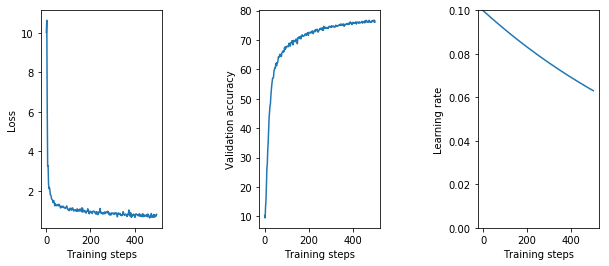

In [74]:
#Plots
p_freq = 2
losses = []
accuracies = []
rates = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    #Plot variables
    if (step % p_freq == 0):
       losses.append(l)
       accuracies.append(accuracy(valid_prediction.eval(), valid_labels))
       rates.append(learning_rate.eval())
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps, p_freq), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, num_steps, p_freq), accuracies)
ax2.set_ylabel("Validation accuracy")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, num_steps, p_freq), rates)
ax3.set_ylabel("Learning rate")
ax3.set_xlabel("Training steps")
ax3.set_ylim([0, 0.1])
plt.show()

Second approach

In [69]:
batch_size = 256
patch_size1 = 5
patch_size2 = 3
depth1 = 6
depth2 = 48
num_hidden = 256
beta = 0.0
num_steps = 501

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Convolution 1 Layer
  # Input channels: num_channels = 1
  # Output channels: depth = 16
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size1, patch_size1, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))

  # Convolution 2 Layer
  # Input channels: depth = 16
  # Output channels: depth = 16
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size2, patch_size2, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
  # Fully Connected Layer (Densely Connected Layer)
  # Use neurons to allow processing of entire image
  layer3_weights = tf.Variable(tf.truncated_normal(
      [3*3*48, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
  # Readout layer: Softmax Layer
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    hidden1 = tf.nn.dropout(tf.nn.relu(conv1 + layer1_biases), 0.5)
    # ksize is kernel size = [1, 2, 2, 1]
    padd1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.conv2d(padd1, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden2 = tf.nn.dropout(tf.nn.relu(conv2 + layer2_biases), 0.5)
    padd2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = padd2.get_shape().as_list()
    reshape = tf.reshape(padd2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases),0.5)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

  regularization = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) \
    + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights)
  loss = tf.reduce_mean(loss + beta * regularization)
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.15, global_step, 2500, 0.1)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 9.940879
Minibatch accuracy: 9.0%
Validation accuracy: 9.9%
Minibatch loss at step 50: 1.973868
Minibatch accuracy: 34.8%
Validation accuracy: 37.1%
Minibatch loss at step 100: 1.471075
Minibatch accuracy: 50.4%
Validation accuracy: 48.1%
Minibatch loss at step 150: 1.396174
Minibatch accuracy: 55.9%
Validation accuracy: 56.1%
Minibatch loss at step 200: 1.065084
Minibatch accuracy: 66.0%
Validation accuracy: 63.0%
Minibatch loss at step 250: 1.117291
Minibatch accuracy: 65.6%
Validation accuracy: 65.4%
Minibatch loss at step 300: 1.093708
Minibatch accuracy: 70.3%
Validation accuracy: 66.5%
Minibatch loss at step 350: 0.960038
Minibatch accuracy: 69.1%
Validation accuracy: 68.9%
Minibatch loss at step 400: 0.908782
Minibatch accuracy: 69.5%
Validation accuracy: 69.7%
Minibatch loss at step 450: 0.954973
Minibatch accuracy: 72.3%
Validation accuracy: 70.8%
Minibatch loss at step 500: 0.818041
Minibatch accuracy: 73.4%
Validation accuracy: 71.3%
Tes

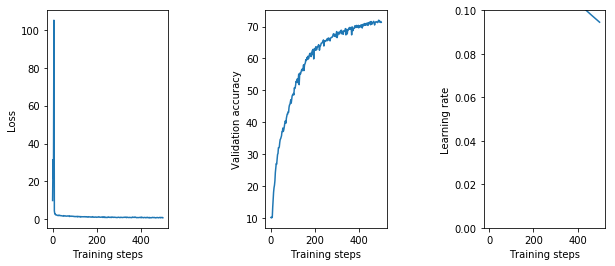

In [70]:
#Plots
p_freq = 2
losses = []
accuracies = []
rates = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    #Plot variables
    if (step % p_freq == 0):
       losses.append(l)
       accuracies.append(accuracy(valid_prediction.eval(), valid_labels))
       rates.append(learning_rate.eval())
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps, p_freq), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, num_steps, p_freq), accuracies)
ax2.set_ylabel("Validation accuracy")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, num_steps, p_freq), rates)
ax3.set_ylabel("Learning rate")
ax3.set_xlabel("Training steps")
ax3.set_ylim([0, 0.1])
plt.show()